In [268]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [269]:
def show_anomaly_graph(data_source, title):
  plt.figure(figsize=(15,6))
  plt.plot(data_source['timestamp'], data_source['temperature'], label='Temperature')
  plt.scatter(data_source['timestamp'][data_source['anomaly'] == 1], data_source['temperature'][data_source['anomaly'] == 1], color='red', label='Anomaly')
  plt.xlabel("Timestamp")
  plt.ylabel("Temperature")
  plt.title(title)
  plt.legend()
  plt.show()

In [278]:
data = pd.read_csv('./sysinfo.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [271]:
data.head()

,cpu_percent,temperature,timestamp
0,0.38,34,2017-05-24 18:41:53.875155
1,0.86,35,2017-05-24 18:42:53.879360
2,0.12,34,2017-05-24 18:43:53.883331
3,0.97,34,2017-05-24 18:44:53.887442
4,0.38,34,2017-05-24 18:45:53.891643


In [272]:
data.shape

(921, 3)

In [273]:
data.describe()

,cpu_percent,temperature
count,921.000000,921.000000
mean,3.096927,33.689468
std,9.083347,4.311157
min,0.000000,30.000000
25%,0.380000,32.000000
50%,0.620000,32.000000
75%,1.120000,33.000000
max,100.000000,61.000000


Każda kolumna posiada taką samą ilość danych, co oznacza, że nie posiadamy żadnych brakujących informacji a naszym zbiorze

Text(0.5, 1.0, 'Timeseries')

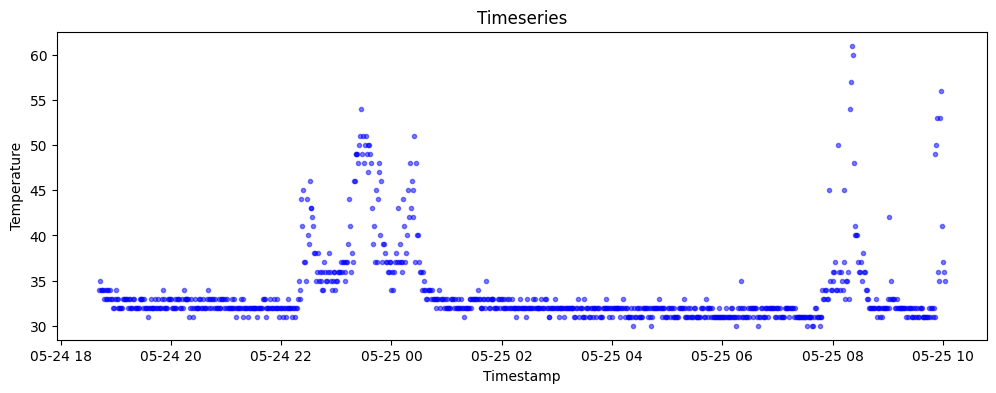

In [279]:
plt.figure(figsize=(12, 4))
plt.plot(data['timestamp'], data['temperature'], 'b.', alpha=0.5)
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Timeseries")

# Las izolacyjny

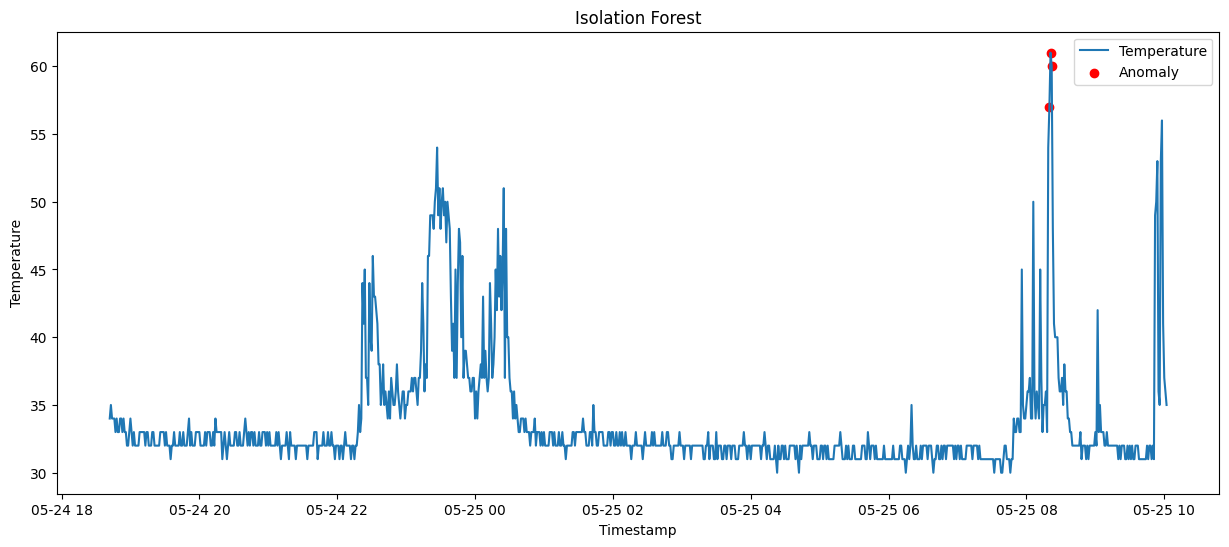

In [275]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

data = pd.read_csv('sysinfo.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

outliers_fraction = float(.003)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data[["temperature"]])
data_temperature_std = pd.DataFrame(np_scaled, columns=data[["temperature"]].columns)

model = IsolationForest(contamination=outliers_fraction)
model.fit(data_temperature_std)

data['anomaly'] = model.predict(data_temperature_std)
data['anomaly'] = data['anomaly'].apply(lambda x: 1 if x == -1 else 0)

show_anomaly_graph(data, title='Isolation Forest')

# HBOS

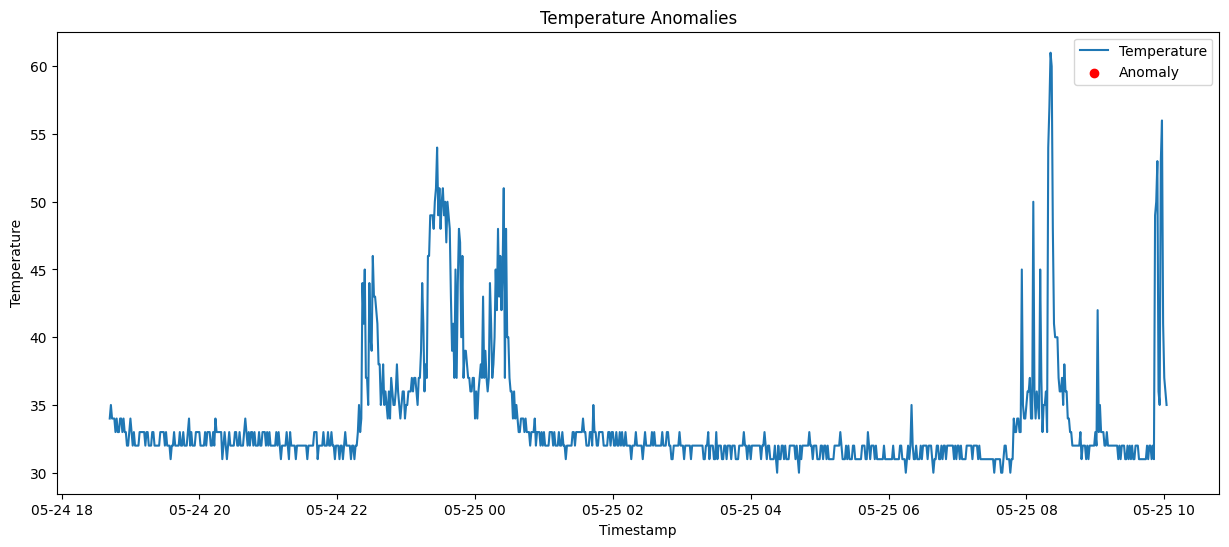

In [276]:
from pyod.models.hbos import HBOS

data = pd.read_csv('./sysinfo.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

model = HBOS(contamination=0.003)

model.fit(data[["temperature"]])
data["anomaly"] = model.predict(data[["temperature"]])

show_anomaly_graph(data, title='Temperature Anomalies')


# K-means

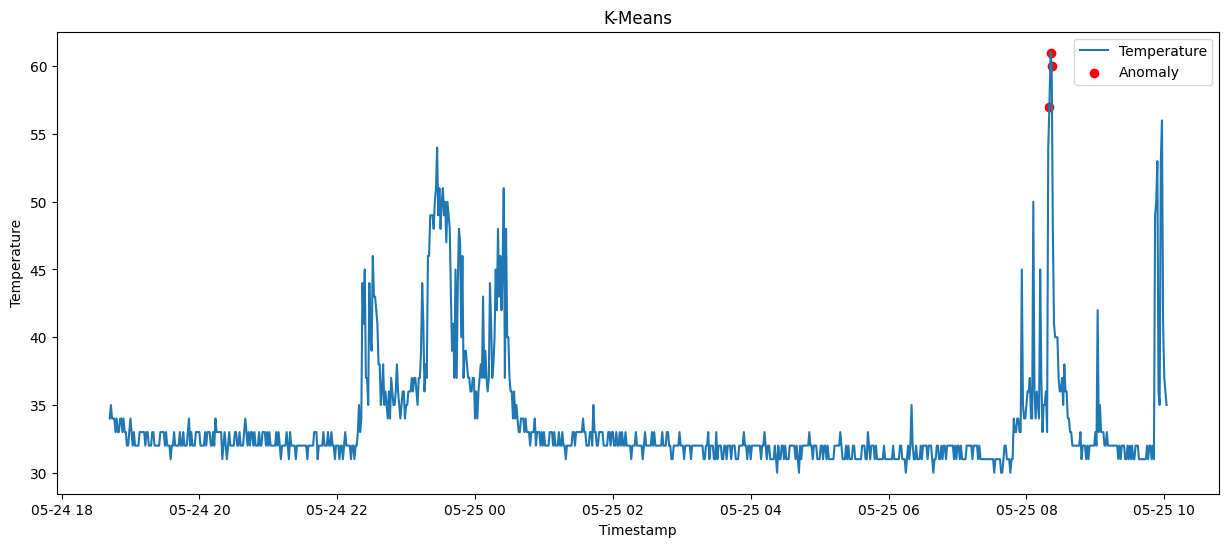

In [277]:
from sklearn.cluster import KMeans
import numpy as np

data = pd.read_csv('./sysinfo.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[['temperature']])

data['distance'] = np.linalg.norm(data[['temperature']] - kmeans.cluster_centers_[data['cluster']], axis=1)

threshold = np.percentile(data['distance'], 99.7)
data['anomaly'] = (data['distance'] > threshold).astype(int)

show_anomaly_graph(data, title="K-Means")